# CNN Model Tuning using Final Augmented Data

## Part 1: Setup

In [1]:
# run helper functions script to load packages, data and functions
%run -i helper_functions.py

In [ ]:
# not in helper functions

import seaborn as sns
import cv2
from math import sin, cos, pi

def plot_img(image, label, axis):
    image = image.reshape(96,96)
    axis.imshow(image, cmap='gray')
    axis.scatter(label[0::2], label[1::2], s=24, marker ='.', c='r')

## Part 3: Create training data scenarios based on options to handle missing values

In [2]:
# create 'partial' (missing values) dataset from train_data

train_data_partial = train_data.dropna()
print("Shape of training dataset with no missing values: {}".format(train_data_partial.shape))

Shape of training dataset with no missing values: (2140, 31)


In [3]:
%%time

# separate data into features and labels using helper functions

X_full = get_features(train_data, dim=2)
y_full = get_labels(train_data)
X_test = get_features(test_data, dim=2)

print("Full training data with missing values:")
print("Training features shape: {}".format(X_full.shape))
print("Training labels shape: {}".format(y_full.shape))
print("Test features shape: {}".format(X_test.shape))

Full training data with missing values:
Training features shape: (7049, 96, 96, 1)
Training labels shape: (7049, 30)
Test features shape: (1783, 96, 96, 1)
CPU times: user 14.9 s, sys: 1.79 s, total: 16.7 s
Wall time: 16.7 s


In [4]:
%%time

# drop rows with missing values
# get features function didn't work after rows were dropped

def load_images(image_data):
    images = []
    for idx, df in image_data.iterrows():
        image = np.array(df['Image'].split(' '), dtype=int)
        image = np.reshape(image, (96,96,1))
        images.append(image)
    images = np.array(images)
    return images

X_partial = load_images(train_data_partial)

y_partial = train_data_partial.drop("Image", axis = 1).to_numpy()

print("Partial training data with NO missing values:")
print("Training features shape: {}".format(X_partial.shape))
print("Training labels shape: {}".format(y_partial.shape))

Partial training data with NO missing values:
Training features shape: (2140, 96, 96, 1)
Training labels shape: (2140, 30)
CPU times: user 2.53 s, sys: 91.2 ms, total: 2.62 s
Wall time: 2.62 s


In [5]:
# image pixels not yet normalized.  Need to divide by 255.
# consider adding as a helper function

def convert_images(image_data):
    temp = np.array(image_data)/255
    return temp

X_full_converted = convert_images(X_full)
X_partial_converted = convert_images(X_partial)
X_test_converted = convert_images(X_test)

NameError: name 'plot_img' is not defined

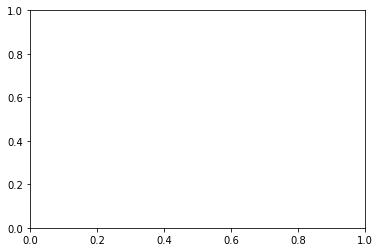

In [6]:
fig, axis = plt.subplots()
plot_img(X_full_converted[210], y_full[210], axis)

In [ ]:
# create function to flip images horizontally

def flip_horizontal(features, labels):
    flipped_labels = []
    flipped_features = np.flip(features, axis=2)
    for index, value in enumerate(labels):
        flipped_labels.append([96.-coor if index%2==0 else coor for index, coor in enumerate(value)])
    return flipped_features, np.asarray(flipped_labels)

In [ ]:
%%time
test_feat, test_lab = flip_horizontal(X_full_converted, y_full)
print(test_feat.shape)
print(test_lab.shape)

In [ ]:
# show example
fig, axis = plt.subplots()
plot_img(test_feat[210], test_lab[210], axis)

In [ ]:
print(type(X_full_converted), X_full_converted.shape)
print(type(X_partial_converted), X_partial_converted.shape)
print(type(y_full), y_full.shape)
print(type(y_partial), y_partial.shape)

In [ ]:
test_feat2, test_lab2 = flip_horizontal(X_partial_converted, y_partial)
print(test_feat2.shape)
print(test_lab2.shape)

In [ ]:
# show example
fig, axis = plt.subplots()
plot_img(test_feat2[210], test_lab2[210], axis)

In [ ]:
# create function to rotate images
# https://in.mathworks.com/matlabcentral/answers/93554-how-can-i-rotate-a-set-of-points-in-a-plane-by-a-certain-angle-about-an-arbitrary-point

# arbitary list of angles to use to rotate the images
angle_list = [5, 7.5, 10, 12.5, 15] 

def perform_rotation(features, labels):
    rotated_labels = []
    rotated_features = []
    for item in angle_list:    
        for angle in [item,-item]:
            M = cv2.getRotationMatrix2D((48,48), angle, 1.0)
            angle_radians = -angle*pi/180. 
            
            # features
            for feat in features:
                rotated_feat = cv2.warpAffine(feat, M, (96,96), flags=cv2.INTER_CUBIC)
                rotated_features.append(rotated_feat)
            
            # labels
            for lab in labels:
                rotated_lab = lab - 48.
                for idx in range(0,len(rotated_lab),2):
                    rotated_lab[idx] = rotated_lab[idx]*cos(angle_radians)-rotated_lab[idx+1]*sin(angle_radians)
                    rotated_lab[idx+1] = rotated_lab[idx]*sin(angle_radians)+rotated_lab[idx+1]*cos(angle_radians)
                rotated_lab += 48.   # Add the earlier subtracted value
                rotated_labels.append(rotated_lab)
            
    return np.reshape(rotated_features,(-1,96,96,1)), np.asarray(rotated_labels)

In [ ]:
%%time
test_feat, test_lab = perform_rotation(X_full_converted, y_full)
print(test_feat.shape)
print(test_lab.shape)

In [ ]:
# show example
fig, axis = plt.subplots()
plot_img(test_feat[210], test_lab[210], axis)

In [ ]:
# create function to update image lighting

# arbitrary list of lighting factors to use to brighten/dim the images
lighting_factor_list = [0.5, 0.75, 1.25, 1.5]

def update_lighting(features, labels):
    updated_features = []
    updated_labels = []
    for item in lighting_factor_list:
        new_features = np.clip(features*item, 0.0, 1.0)
        updated_features.extend(new_features)
        updated_labels.extend(labels)
    return np.asarray(updated_features), np.asarray(updated_labels)

In [ ]:
%%time
test_feat, test_lab = update_lighting(X_full_converted, y_full)
print(test_feat.shape)
print(test_lab.shape)

In [ ]:
# create function to move the center of the image up, down, left and right

# arbitrary list of pixel values to use to move center of image
pixel_moves = [4, 8, 16, 32]

def move_center(features, labels):
    shifted_features = []
    shifted_labels = []
    for item in pixel_moves:
        for (xval,yval) in [(item,item),(-item,item),(item,-item),(-item,-item)]:
            M = np.float32([[1,0,xval],[0,1,yval]])
            for feat, lab in zip(features, labels):
                shifted_feature = cv2.warpAffine(feat, M, (96,96), flags=cv2.INTER_CUBIC)
                shifted_label = np.array([(point+xval) if idx%2==0 else (point+yval) for idx, point in enumerate(lab)])
                if np.all(0.0<shifted_label) and np.all(shifted_label<96.0):
                    shifted_features.append(shifted_feature.reshape(96,96,1))
                    shifted_labels.append(shifted_label)
    shifted_labels = np.clip(shifted_labels,0.0,96.0)
    return np.asarray(shifted_features), shifted_labels

In [ ]:
%%time
test_feat, test_lab = move_center(X_full_converted, y_full)
print(test_feat.shape)
print(test_lab.shape)

In [ ]:
# create function to add noise to images

# arbitrary noise factor
noise_factor = 0.02

def add_noise(features, labels):
    noise_features = []
    for feat in features:
        noise_feat = cv2.add(feat, noise_factor*np.random.randn(96,96,1))
        noise_features.append(noise_feat.reshape(96,96,1))
    return np.asarray(noise_features), labels

In [ ]:
%%time
test_feat, test_lab = add_noise(X_full_converted, y_full)
print(test_feat.shape)
print(test_lab.shape)

In [ ]:
%%time

# build up training dataset using augmentation methods

# for partial dataset

# # control table used to apply augmentation methods; code currently assumes all are set to True
# # ignore
# flip = True
# rotate = True
# light = True
# move = True
# noise = True

# progress through augmentations
print("\nPartial training data with NO missing values\nBefore augmentation steps:\nFeatures shape: {}     Labels shape: {}".format(X_partial_converted.shape, y_partial.shape))

# flip
X_partial_flip, y_partial_flip = flip_horizontal(X_partial_converted, y_partial)
X_partial_accum1 = np.concatenate((X_partial_converted, X_partial_flip))
y_partial_accum1 = np.concatenate((y_partial, y_partial_flip))
print("\nAfter flipping horizontally:\nFeatures shape: {}     Labels shape: {}".format(X_partial_accum1.shape, y_partial_accum1.shape))

# rotate
X_partial_rotate, y_partial_rotate = perform_rotation(X_partial_converted, y_partial)
X_partial_accum2 = np.concatenate((X_partial_accum1, X_partial_rotate))
y_partial_accum2 = np.concatenate((y_partial_accum1, y_partial_rotate))
print("\nAfter performing rotations:\nFeatures shape: {}     Labels shape: {}".format(X_partial_accum2.shape, y_partial_accum2.shape))
    
# light
X_partial_light, y_partial_light = update_lighting(X_partial_converted, y_partial)
X_partial_accum3 = np.concatenate((X_partial_accum2, X_partial_light))
y_partial_accum3 = np.concatenate((y_partial_accum2, y_partial_light))
print("\nAfter updating lighting:\nFeatures shape: {}     Labels shape: {}".format(X_partial_accum3.shape, y_partial_accum3.shape))
    
# move
X_partial_move, y_partial_move = move_center(X_partial_converted, y_partial)
X_partial_accum4 = np.concatenate((X_partial_accum3, X_partial_move))
y_partial_accum4 = np.concatenate((y_partial_accum3, y_partial_move))
print("\nAfter moving the image center:\nFeatures shape: {}     Labels shape: {}".format(X_partial_accum4.shape, y_partial_accum4.shape))
    
# add noise
X_partial_noise, y_partial_noise = add_noise(X_partial_converted, y_partial)
X_partial_accum5 = np.concatenate((X_partial_accum4, X_partial_noise))
y_partial_accum5 = np.concatenate((y_partial_accum4, y_partial_noise))
print("\nAfter adding noise:\nFeatures shape: {}     Labels shape: {}".format(X_partial_accum5.shape, y_partial_accum5.shape))
    

## Part 4: Training a CNN on the Augmented Data, Evaluating on Dev Set

In [ ]:
from sklearn.model_selection import train_test_split #Pull this into helper file

X_train, X_dev, y_train, y_dev = train_test_split(X_partial_accum5, y_partial_accum5, test_size=0.2, random_state=42)
print(f"Train examples: {X_train.shape[0]}")
print(f"Train labels: {y_train.shape[0]}")
print(f"Dev examples: {X_dev.shape[0]}")
print(f"Dev labels {y_dev.shape[0]}")

In [ ]:
# Setting example image dimensions
img_rows = 96
img_cols = 96

# ===Begin Specifying Baseline CNN Architecture===
cnn_model = Sequential()

# 32 Convolution filters used
cnn_model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(img_rows, img_cols, 1)))

# Choose best features using max pooling layer 
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #2d can be used for 2 dimensional input. No depth here.

# 64 Convolution filters used, each of size 3x3
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))

# Choose best features using max pooling layer 
cnn_model.add(MaxPooling2D(pool_size=(2, 2))) #2d can be used for 2 dimensional input. No depth here.

# Optional dropout layer. No need for baseline model.
# cnn_model.add(Dropout(0.2)) #20% of the nodes are not going to activate at each layer of the network.

# Flatten convolution features to pass through into the feed forward network. So 2d layer to 1d layer.
cnn_model.add(Flatten())

cnn_model.add(Dense(units=128, input_dim=128, activation='relu'))
# 50 node network. Must be smaller than previous layer.
# Input dimensions is 128 because 

# During gradient descent, you're refining 50 nod
cnn_model.add(Dense(units=30, input_dim=50))  #10 node network

# Summarize Model
cnn_model.summary()

In [ ]:
# Compile and train the CNN
cnn_model.compile(optimizer="adam", loss='mean_squared_error', metrics=['mae'])

cnn_model.fit(X_train, y_train, epochs = 50, batch_size = 256, validation_split = 0.2)

In [ ]:
# Saving the model. This results in an error, but we might want to try to figure out how to store it.
# import joblib
# joblib.dump(cnn_model, "baseline_model_save")

In [ ]:
cnn_y_dev_pred = cnn_model.predict(X_dev)

from sklearn.metrics import mean_squared_error #Eventually Add to helper file

print('Baseline CNN Dev RMSE: %.2f'
      % mean_squared_error(y_dev, cnn_y_dev_pred, squared=False))